In [ ]:
!gdown https://drive.google.com/drive/folders/16pVdS-KxgISIo87RcDleZPxegH8agAN8 -O /content/ --folder --quiet

In [ ]:
# !pip uninstall -q cody --y
!pip install -q -U pandas==1.4.1
!pip install -q --no-index --find-links=/content/tutorials/ cody==0.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 74.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 1.4.1 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import cody.load.datasets as datasets
from cody.load.datasets.dxy import * # dxy_weight, co6, co10, cv, gv
import cody.models as models
import cody.evaluation.eval as evaluation
import cody.visualization.xai as xai
import cody.preprocess.utils as utils

In [ ]:
import pandas as pd 
import numpy as np

from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.tseries.offsets import MonthEnd
from multiprocessing import Process

In [ ]:
b_date = '1999-12'
e_date = '2023-04'

# 0. Load Data

In [ ]:
Xm, lSm, _, _ = datasets.dxy.load(b_date, e_date, '/content/tutorials/input')
y = datasets.dxy.set_target_month(lSm, 1) # 1 month ahead DXY

print(y.tail(5))

Date
2022-11-30   -0.034525
2022-12-31   -0.016451
2023-01-31    0.008541
2023-02-28    0.001283
2023-03-31   -0.019566
Freq: M, dtype: float64


In [ ]:
Tm = y.index.intersection(Xm.index)
Fm = pd.date_range('2018', Tm[-1], freq='M')
T = len(Tm)
n_training = T - len(Fm)
idx = pd.IndexSlice

# set predictors for
X_cg10 = Xm.loc[Tm, idx[cv + gv, co10]].apply(utils.normalize)
X_cg06 = Xm.loc[Tm, idx[cv + gv, co6]].apply(utils.normalize)

# dataset for regression
X_reg = Xm.loc[Tm, idx[cv + gv, co6]].groupby(level=0, axis=1).mean().apply(utils.normalize)

# dict of various predictors
X_dict = {'cg06':X_cg06, 'cg10':X_cg10, 'reg':X_reg}


# 간단 전망모형 만들기(랜덤포레스트)

In [ ]:
X = Xm.loc[Tm].sort_index(axis=1)

In [ ]:
y = y.loc[Tm]

In [ ]:
X.shape

(268, 132)

In [ ]:
y.shape

(268,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor()

2023.2월까지 데이터를 이용하여 랜덤포레스트 전망모형을 학습하고, 23.3월 설명변수를 이용하여 4월 상승률 예측

In [ ]:
X_train = X.loc[:'2023-02-28']
y_train = y.loc[:'2023-02-28']

In [ ]:
model.fit(X_train.values, y_train)

RandomForestRegressor()

In [ ]:
pred_train = model.predict(X_train.values)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
mse = mean_squared_error(y_train, pred_train)
mae = mean_absolute_error(y_train, pred_train)
r2 = r2_score(y_train, pred_train)
print(f"mse: {mse:.4f}, mae: {mae:.4f}, r2: {r2:.4f}")

mse: 0.0000, mae: 0.0049, r2: 0.8813


In [ ]:
mse = np.mean((pred_train-y_train)**2)
mae = np.mean(np.abs(pred_train-y_train))
r2 = 1 - (np.sum((pred_train-y_train)**2)/np.sum((y_train-y_train.mean())**2))
print(f"mse: {mse:.4f}, mae: {mae:.4f}, r2: {r2:.4f}")

mse: 0.0000, mae: 0.0049, r2: 0.8813


In [ ]:
X_202304 = X.loc[['2023-03-31']]

pred_202304 = model.predict(X_202304.values)

In [ ]:
print(f"2023.4월 dxy 상승률은 {pred_202304[0]:.4f}")

2023.4월 dxy 상승률은 -0.0024


# 1. 하이퍼파라미터 튜닝

- 2017.12월까지 데이터를 이용하여 최적 하이퍼파라미터를 탐색하고, 2018.1월 이후 데이터를 이용하여 여러 ML 전망모형의 예측력 평가
- holdout, KFold, TimeSerieSplit

In [ ]:
X_train = X.loc[:'2017-12-31']
y_train = y.loc[:'2017-12-31']

## holdout validation

- 전체 학습데이터의 마지막 30% 기간(약 5년)을 모형검증(표본외 예측력 평가)에 활용

### 다양한 ML 알고리즘

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
17*12*0.3/12

5.1

In [ ]:
model = ExtraTreesRegressor()

In [ ]:
model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
model.fit(X_train.loc[:'2012-12-31'].values, y_train.loc[:'2012-12-31'])

ExtraTreesRegressor()

In [ ]:
pred_val = model.predict(X_train.loc['2013-01-01':].values)

In [ ]:
y_val = y_train.loc['2013-01-01':]

In [ ]:
mse = mean_squared_error(y_val, pred_val)
mae = mean_absolute_error(y_val, pred_val)
r2 = r2_score(y_val, pred_val)
print(f"mse: {mse:.4f}, mae: {mae:.4f}, r2: {r2:.4f}")

mse: 0.0002, mae: 0.0122, r2: 0.0750


### 최적 하이퍼파라미터 탐색

- 랜덤서치
- 그리드서치

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
params = dict(n_estimators=[1000],
              max_depth=randint(2, 11),
              bootstrap=[False],
              max_features=uniform(loc=0.1, scale=1),
             )

hparams = ['param_max_depth', 'param_max_features']
targets = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score']

In [ ]:
from sklearn.model_selection import KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
train_size = len(X_train)
val_size = len(X_train.loc['2013-01-01':])

In [ ]:
ho = PredefinedSplit([-1]*(train_size - val_size) + [0]*val_size)

In [ ]:
ext_ho = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, cv=ho, return_train_score=True,
                            scoring='r2', n_iter=5, verbose=1, n_jobs=-1)
ext_ho.fit(X_train.values, y_train)

Fitting 1 folds for each of 5 candidates, totalling 5 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=ExtraTreesRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe1807839a0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe1807821a0>,
                                        'n_estimators': [10000]},
                   return_train_score=True, scoring='r2', verbose=1)

In [ ]:
#joblib.dump(ext_ho, 'pickles/ext_ho.pkl')
#ext_ho = joblib.load("pickles/ext_ho.pkl")
df = pd.DataFrame(ext_ho.cv_results_).drop('params', axis=1)
display(df[hparams + targets])

,param_max_depth,param_max_features,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score
0,2,0.215672,0.054664,0.0,0.255079,0.0,4
1,5,1.098868,NaN,NaN,NaN,NaN,5
2,4,0.638002,0.085525,0.0,0.597857,0.0,1
3,9,0.604225,0.065899,0.0,0.983256,0.0,3
4,5,0.876804,0.075205,0.0,0.745044,0.0,2


## KFold validation

In [ ]:
kf = KFold(n_splits=5)

In [ ]:
ext_kf = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, cv=kf, return_train_score=True,
                            scoring='r2', n_iter=5, verbose=1, n_jobs=-1)
ext_kf.fit(X_train.values, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=ExtraTreesRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe1804cc940>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe1804ccbb0>,
                                        'n_estimators': [1000]},
                   return_train_score=True, scoring='r2', verbose=1)

In [ ]:
df = pd.DataFrame(ext_kf.cv_results_).drop('params', axis=1)
display(df[hparams + targets])

,param_max_depth,param_max_features,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score
0,9,0.355336,0.017580,0.156804,0.975902,0.007165,2
1,6,0.358392,0.015340,0.141619,0.816795,0.023171,3
2,9,0.905057,-0.021776,0.242235,0.984404,0.005557,5
3,10,0.526582,-0.006555,0.193725,0.991485,0.002957,4
4,4,0.289571,0.036972,0.099545,0.552906,0.015589,1


## Walk-forward (TimeSeriesSplit) Validation

- ts = [(1999-2012, 2013), (1999-2013, 2014), ..., (1999-2016, 2017)]

In [ ]:
fold_size = 12
n_folds = 5
base_size = len(X_train) - n_folds * fold_size
ts = []
for i in range(n_folds):
    ts.append((list(range(base_size + fold_size*i)), list(range(base_size + fold_size*i, base_size + fold_size*(i+1)))))

In [ ]:
ext_ts = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, cv=ts, return_train_score=True,
                            scoring='r2', n_iter=5, verbose=1, n_jobs=-1)
ext_ts.fit(X_train.values, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
                         156]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
                         168]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19...
                         204])],
                   estimator=ExtraTreesRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe1804cc940>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe1804ccbb0>,
                                        'n_estimators': [1000]},
                   return_train_score=True, scoring='r2', verbose=1)

In [ ]:
df = pd.DataFrame(ext_ts.cv_results_).drop('params', axis=1)
display(df[hparams + targets])

,param_max_depth,param_max_features,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score
0,3,1.084975,NaN,NaN,NaN,NaN,5
1,5,0.134215,-0.209107,0.281964,0.626781,0.017312,4
2,3,0.47784,-0.174975,0.224649,0.418224,0.016385,1
3,4,0.341279,-0.175928,0.252885,0.550672,0.017523,2
4,4,0.184692,-0.193495,0.258896,0.513046,0.016560,3


# 2. 예측력 평가

- 2018년 이후 기간에 대해 모형별 예측오차를 계산하고 평가

In [ ]:
results_dir = '/content/tutorials/results'
models_dir = '/content/tutorials/models'

In [ ]:
# dataframe that stores predictions generated by ml, reg, and ensemble models
pred = pd.DataFrame(index=Fm, dtype=float)

# actual value
pred['y'] = y.loc[Fm]

# random walk: no change
pred['nc'] = 0

## 2-1. ML Models

In [ ]:
import joblib

In [ ]:
print(models.ml.get_model_list())

['ElasticNet', 'ExtraTrees']


In [ ]:
ml_names = ['ent_cg06', 
            'ent_cg10', 
            'ext_cg06', 
            'ext_cg10']

ml_models = [models.ml.ElasticNet(alpha=0.33, l1_ratio=0.002, fit_intercept=False),
             models.ml.ElasticNet(alpha=0.15, l1_ratio=0.02, fit_intercept=False),
             models.ml.ExtraTrees(n_estimators=10000, max_features=1.0, max_depth=4),
             models.ml.ExtraTrees(n_estimators=10000, max_features=1.0, max_depth=3)]

In [ ]:
pred_ml = pd.DataFrame(index=Fm, dtype=float)

for name, model in zip(ml_names, ml_models):
    data_key = name.split('_')[1]    # 'cg6', 'cg10'
    X = X_dict[data_key]

    for i in tqdm(range(n_training, T)):
        if (Tm[i].month == 1) and (Tm[i].year in [2018, 2023]):
            X_train = X.loc[idx[Tm[:i], :]]
            y_train = y.loc[idx[Tm[:i]]]
            model.fit(X_train, y_train)
            joblib.dump(model, f'{models_dir}/{name}_{Tm[i]:%Y-%m}')
        else:
            pass

        predictor = X.loc[[Tm[i]]]
        pred_ml.loc[Tm[i], name] = model.predict(predictor)[0]
    
pred_ml.to_pickle(f'{results_dir}/pred_ml.pkl')

100%|██████████| 63/63 [01:01<00:00,  1.03it/s]


In [ ]:
pred = pd.concat([pred, pd.read_pickle(f'{results_dir}/pred_ml.pkl')], axis=1)
pred.tail(5)

,y,nc,ent_cg06,ent_cg10,ext_cg06,ext_cg10
2022-11-30,-0.034525,0,-0.016895,-0.009695,-0.016977,-0.014504
2022-12-31,-0.016451,0,-0.015087,-0.008264,-0.008329,-0.008541
2023-01-31,0.008541,0,-0.017227,-0.006425,-0.006084,-0.003955
2023-02-28,0.001283,0,-0.009578,-0.002402,-0.000354,0.003468
2023-03-31,-0.019566,0,-0.009462,-0.001113,-0.002616,-0.000100


## 2-2. Regression Models

In [ ]:
reg_eqn = ['y ~ 1 + dxy + ddxy', 
           'y ~ 1 + dxy + ddxy + infl', 
           'y ~ 1 + dxy + ddxy + un',
           'y ~ 1 + dxy + ddxy + bill',
           'y ~ 1 + dxy + ddxy + note',
           'y ~ 1 + dxy + ddxy + bond',
           'y ~ 1 + dxy + ddxy + vix', 
           'y ~ 1 + dxy + ddxy + t10', 
           'y ~ 1 + dxy + ddxy + t5', 
           'y ~ 1 + dxy + ddxy + ted', 
           'y ~ 1 + dxy + ddxy + epu', 
           'y ~ 1 + dxy + ddxy + infl + un',                                                              # 테일러룰
           'y ~ 1 + dxy + ddxy + bill + note + bond',                                                     # 내외금리차
           'y ~ 1 + dxy + ddxy + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted',             # 글로벌(기간스프레드, 빅스, 테드)
           'y ~ 1 + dxy + ddxy + infl + un + bill + note + bond',                                         # 테일러룰 + 내외금리차
           'y ~ 1 + dxy + ddxy + infl + un + bill + note + bond + dp + pe + sret12 + ivol + iskew',       # 테일러룰 + 내외금리차 + 주식/외환시장
           'y ~ 1 + dxy + ddxy + dp + pe + sret12 + ivol + iskew',                                        # 주식/외환시장
           'y ~ 1 + dxy + ddxy + infl + un + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted', # 테일러 + 글로벌
           'y ~ 1 + dxy + ddxy + infl + un + dp + pe + sret12 + ivol + iskew',                            # 테일러 + 주식/외환
           'y ~ 1 + dxy + ddxy + bill + note + bond + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted',   # 내외금리 + 글로벌
           'y ~ 1 + dxy + ddxy + bill + note + bond + dp + pe + sret12 + ivol + iskew',                   # 내외금리 + 주식/외환
           'y ~ 1 + dxy + ddxy + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted + dp + pe + sret12 + ivol + iskew',   # 글로벌 + 주식/외환
           'y ~ 1 + dxy + ddxy + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted']

reg_names = ['r' + str(i) + '_reg' for i in range(len(reg_eqn))]
reg_dict = dict(zip(reg_names, reg_eqn))

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
pred_reg = pd.DataFrame(index=Fm, dtype=float)

for name in tqdm(reg_dict):
    for i in range(n_training, T):  
        if (Tm[i].month == 1):
            df = pd.concat([X_reg.loc[Tm[:i], :], y.loc[Tm[:i]].to_frame('y')], axis=1)
            reg = smf.ols(reg_dict[name], data = df).fit()
            joblib.dump(reg, f"{models_dir}/{name}_{Tm[i]:%Y-%m}")
        else:
            pass
        pred_reg.loc[Tm[i], name] = reg.predict(X_reg.loc[Tm[i], :])[0]

pred_reg.to_pickle(f'{results_dir}/pred_reg.pkl')

100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


In [ ]:
pred = pd.concat([pred, pd.read_pickle(f'{results_dir}/pred_reg.pkl')], axis=1)
pred.tail(5)

,y,nc,ent_cg06,ent_cg10,ext_cg06,ext_cg10,r0_reg,r1_reg,r2_reg,r3_reg,...,r13_reg,r14_reg,r15_reg,r16_reg,r17_reg,r18_reg,r19_reg,r20_reg,r21_reg,r22_reg
2022-11-30,-0.034525,0,-0.016895,-0.009695,-0.016977,-0.014504,-0.014731,-0.015958,-0.01261,-0.013677,...,-0.010518,-0.019272,-0.015955,-0.009559,-0.011547,-0.010046,-0.018987,-0.014219,-0.008402,-0.010518
2022-12-31,-0.016451,0,-0.015087,-0.008264,-0.008329,-0.008541,-0.014648,-0.017736,-0.012904,-0.013899,...,-0.010021,-0.015468,-0.014925,-0.010359,-0.014736,-0.013217,-0.011433,-0.01083,-0.010131,-0.010021
2023-01-31,0.008541,0,-0.017227,-0.006425,-0.006084,-0.003955,-0.008239,-0.013786,-0.007024,-0.007603,...,-0.007756,-0.012662,-0.017327,-0.007618,-0.015309,-0.013981,-0.007167,-0.008936,-0.009333,-0.007756
2023-02-28,0.001283,0,-0.009578,-0.002402,-0.000354,0.003468,0.000216,-0.00547,0.001051,0.000941,...,0.001806,-0.002944,-0.003767,0.004965,-0.006015,-0.001897,0.003047,0.004592,0.002557,0.001806
2023-03-31,-0.019566,0,-0.009462,-0.001113,-0.002616,-0.000100,-0.002242,-0.007566,-0.001161,-0.001487,...,-0.002412,-0.011253,-0.01113,0.002163,-0.007863,-0.003584,-0.002747,-0.003466,-0.001415,-0.002412


## 2-3. Ensemble Models

In [ ]:
combs_ml = [['ent_cg06', 'ext_cg06'], ['ent_cg10', 'ext_cg10']]
combs_ml_reg = [['ent_cg06', 'ext_cg06'] + [ml] for ml in reg_names] + [['ent_cg10', 'ext_cg10'] + [ml] for ml in reg_names]
combs = combs_ml + combs_ml_reg

ens_names = ['ens' + str(i) for i in range(len(combs))]
ens_ml = ['ens' + str(i) for i in range(0, len(combs_ml))]
ens_ml_reg = ['ens' + str(i) for i in range(len(combs_ml), len(combs))]

ens_dict = dict(zip(ens_names, combs))

for name, models in zip(ens_names, combs):
    pred[name] = pred[models].mean(axis=1)
    
pred = pred.astype(float)

In [ ]:
pred.tail(5)

,y,nc,ent_cg06,ent_cg10,ext_cg06,ext_cg10,r0_reg,r1_reg,r2_reg,r3_reg,...,ens38,ens39,ens40,ens41,ens42,ens43,ens44,ens45,ens46,ens47
2022-11-30,-0.034525,0.0,-0.016895,-0.009695,-0.016977,-0.014504,-0.014731,-0.015958,-0.012610,-0.013677,...,-0.011572,-0.014490,-0.013384,-0.011253,-0.011915,-0.011415,-0.014395,-0.012806,-0.010867,-0.011572
2022-12-31,-0.016451,0.0,-0.015087,-0.008264,-0.008329,-0.008541,-0.014648,-0.017736,-0.012904,-0.013899,...,-0.008942,-0.010758,-0.010577,-0.009054,-0.010513,-0.010007,-0.009413,-0.009211,-0.008978,-0.008942
2023-01-31,0.008541,0.0,-0.017227,-0.006425,-0.006084,-0.003955,-0.008239,-0.013786,-0.007024,-0.007603,...,-0.006045,-0.007681,-0.009236,-0.005999,-0.008563,-0.008120,-0.005849,-0.006439,-0.006571,-0.006045
2023-02-28,0.001283,0.0,-0.009578,-0.002402,-0.000354,0.003468,0.000216,-0.005470,0.001051,0.000941,...,0.000957,-0.000626,-0.000900,0.002010,-0.001649,-0.000277,0.001371,0.001886,0.001208,0.000957
2023-03-31,-0.019566,0.0,-0.009462,-0.001113,-0.002616,-0.000100,-0.002242,-0.007566,-0.001161,-0.001487,...,-0.001208,-0.004155,-0.004114,0.000317,-0.003025,-0.001599,-0.001320,-0.001560,-0.000876,-0.001208


# 3. Analyze and Evaluate Results

## 3-1. Mean Directional Accuracy

In [ ]:
all_names = ml_names + reg_names + ens_names
direction = pred[all_names].copy()*0
for i, c in itertools.product(pred.index, all_names):
    if np.sign(pred.loc[i, c]) == np.sign(pred.loc[i, 'y']):
        direction.loc[i, c] = 1

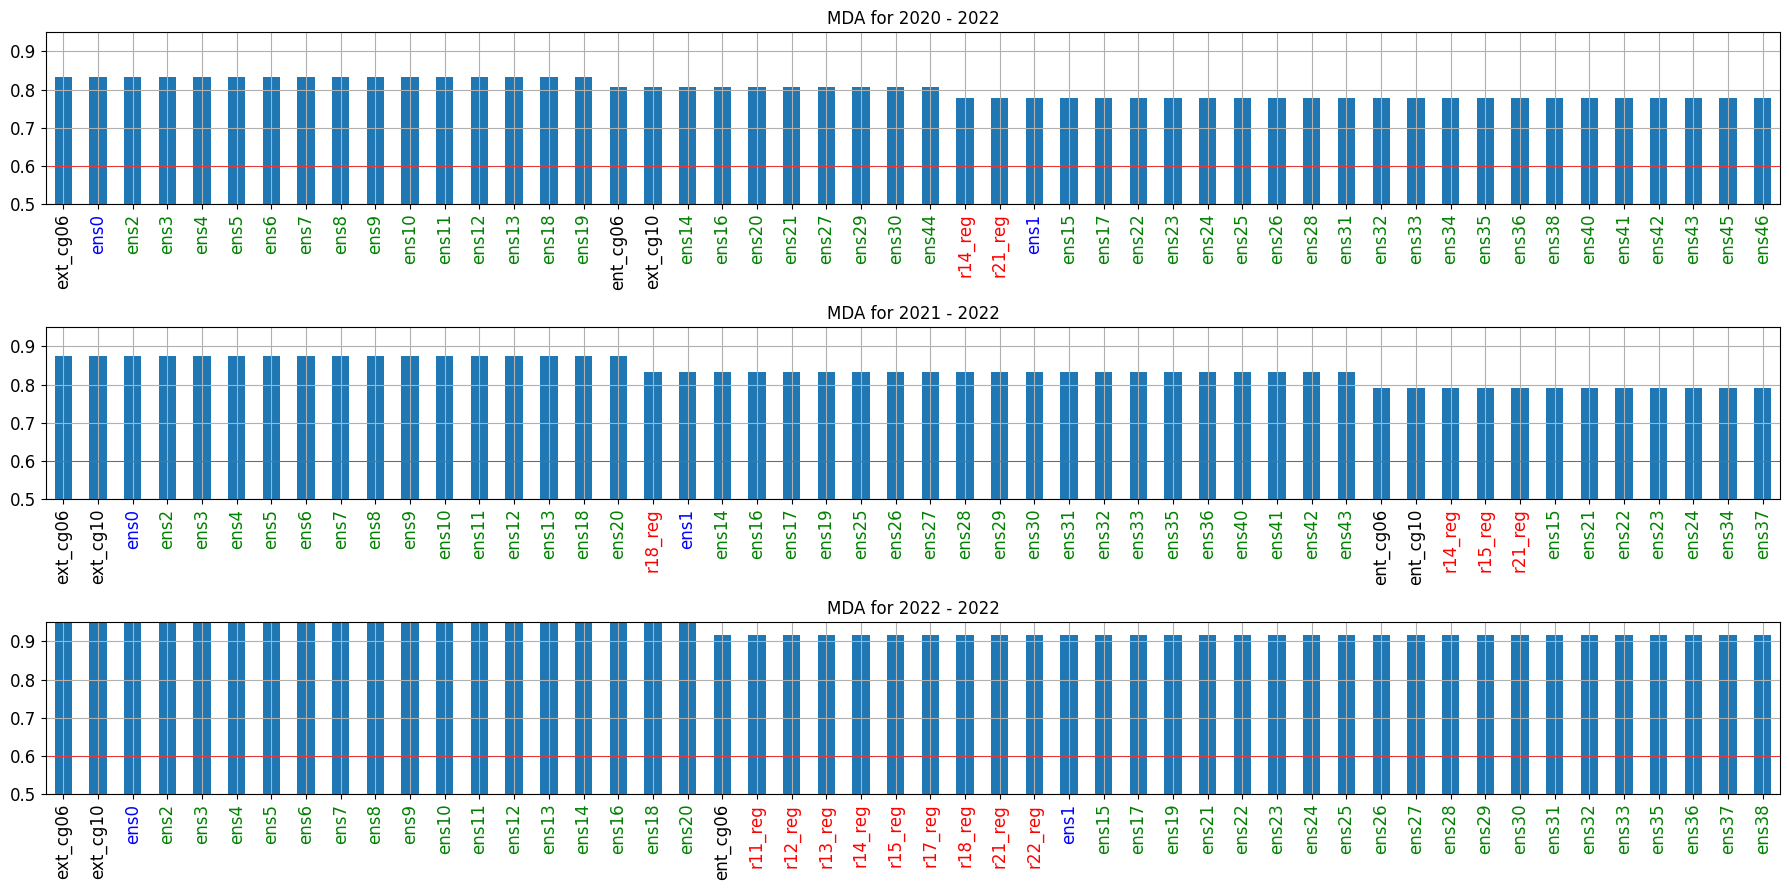

In [ ]:
years = [str(i) for i in range(2020, 2023)]
fig, axs = plt.subplots(len(years), 1, figsize=(18, 3*len(years)))
for ax, year in zip(axs, years):
    direction.loc[year:'2022-12-31'].apply(lambda x: x.sum()/len(x)).nlargest(50).plot.bar(ylim=(0.5, 0.95), grid=True, width=0.5, rot=90, fontsize=12, ax=ax)
    ax.axhline(y=0.6, color='red', lw=0.5)
    for tick in ax.get_xticklabels():
        if tick.get_text() in reg_names:   tick.set_color('red')
        elif tick.get_text() in ens_ml:     tick.set_color('blue')
        elif tick.get_text() in ens_ml_reg: tick.set_color('green')
    ax.set_title(f'MDA for {year} - 2022')
fig.tight_layout()

In [ ]:
for i in [1, 16, 17, 19, 26, 27, 46]:
    print(i, ':', *combs[i])

1 : ent_cg10 ext_cg10
16 : ent_cg06 ext_cg06 r14_reg
17 : ent_cg06 ext_cg06 r15_reg
19 : ent_cg06 ext_cg06 r17_reg
26 : ent_cg10 ext_cg10 r1_reg
27 : ent_cg10 ext_cg10 r2_reg
46 : ent_cg10 ext_cg10 r21_reg


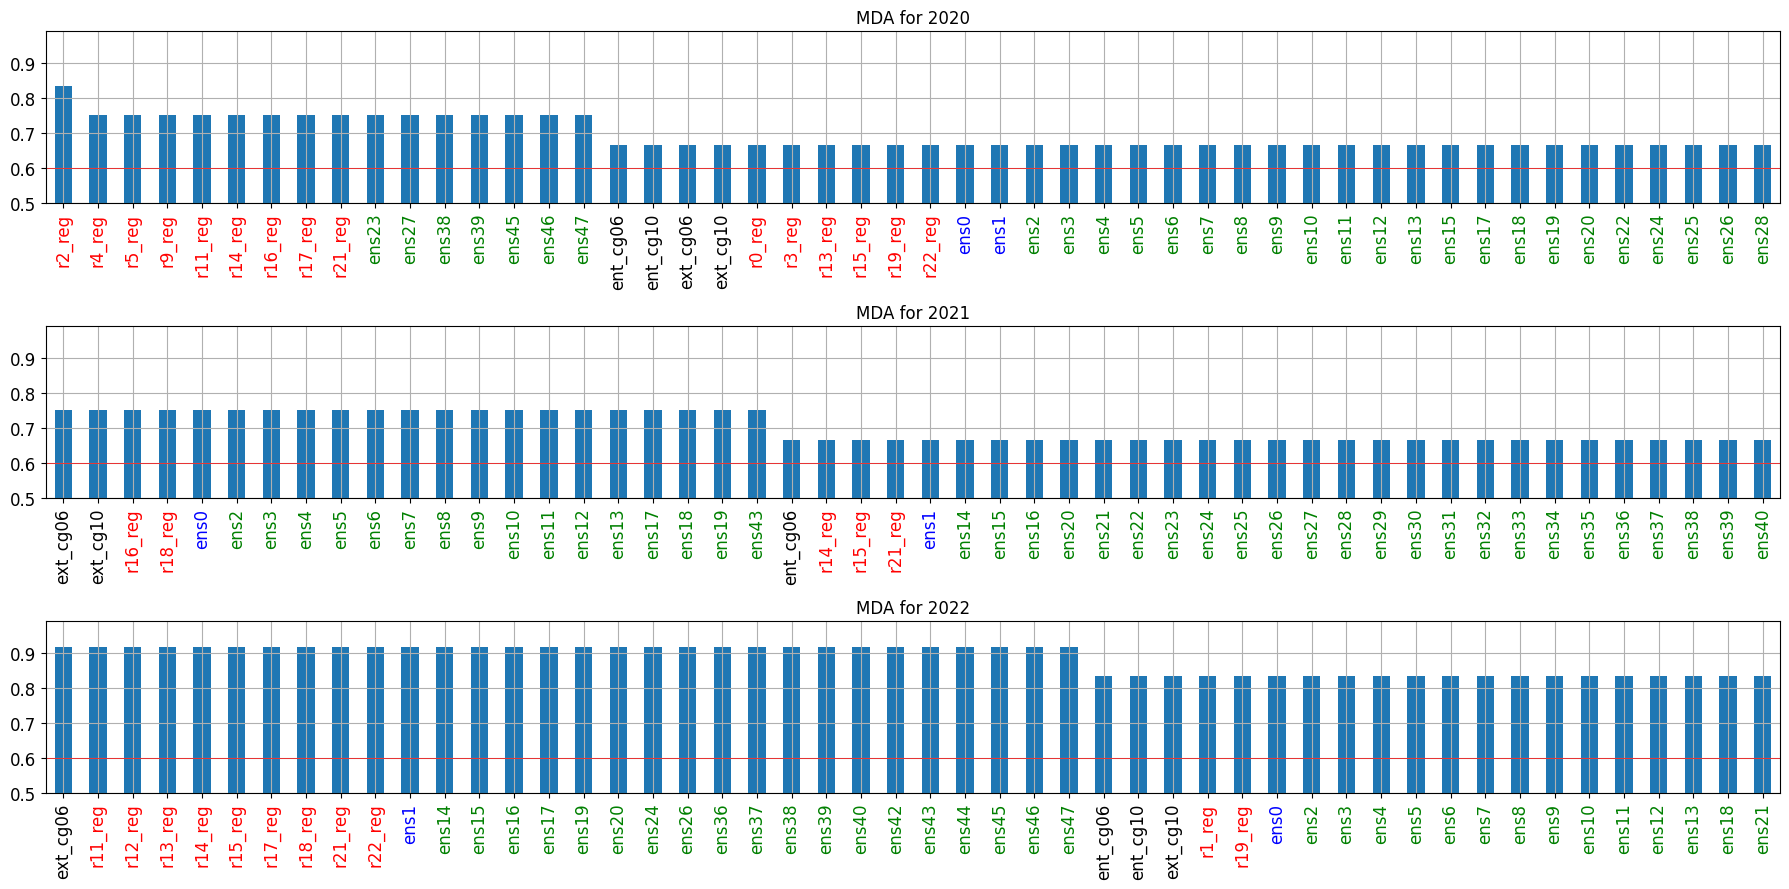

In [ ]:
fig, axs = plt.subplots(len(years), 1, figsize=(18, 3*len(years)))
for ax, year in zip(axs, years):
    direction.loc[year].apply(lambda x: x.sum()/len(x)).nlargest(50).plot.bar(ylim=(0.5, 0.99), grid=True, width=0.5, rot=90, fontsize=12, ax=ax)
    ax.axhline(y=0.6, color='red', lw=0.5)
    for tick in ax.get_xticklabels():
        if tick.get_text() in reg_names:   tick.set_color('red')
        elif tick.get_text() in ens_ml:     tick.set_color('blue')
        elif tick.get_text() in ens_ml_reg: tick.set_color('green')
    ax.set_title(f'MDA for {year}')
fig.tight_layout()

## 3-2. Evaluation(C-W stat and $R^2$)

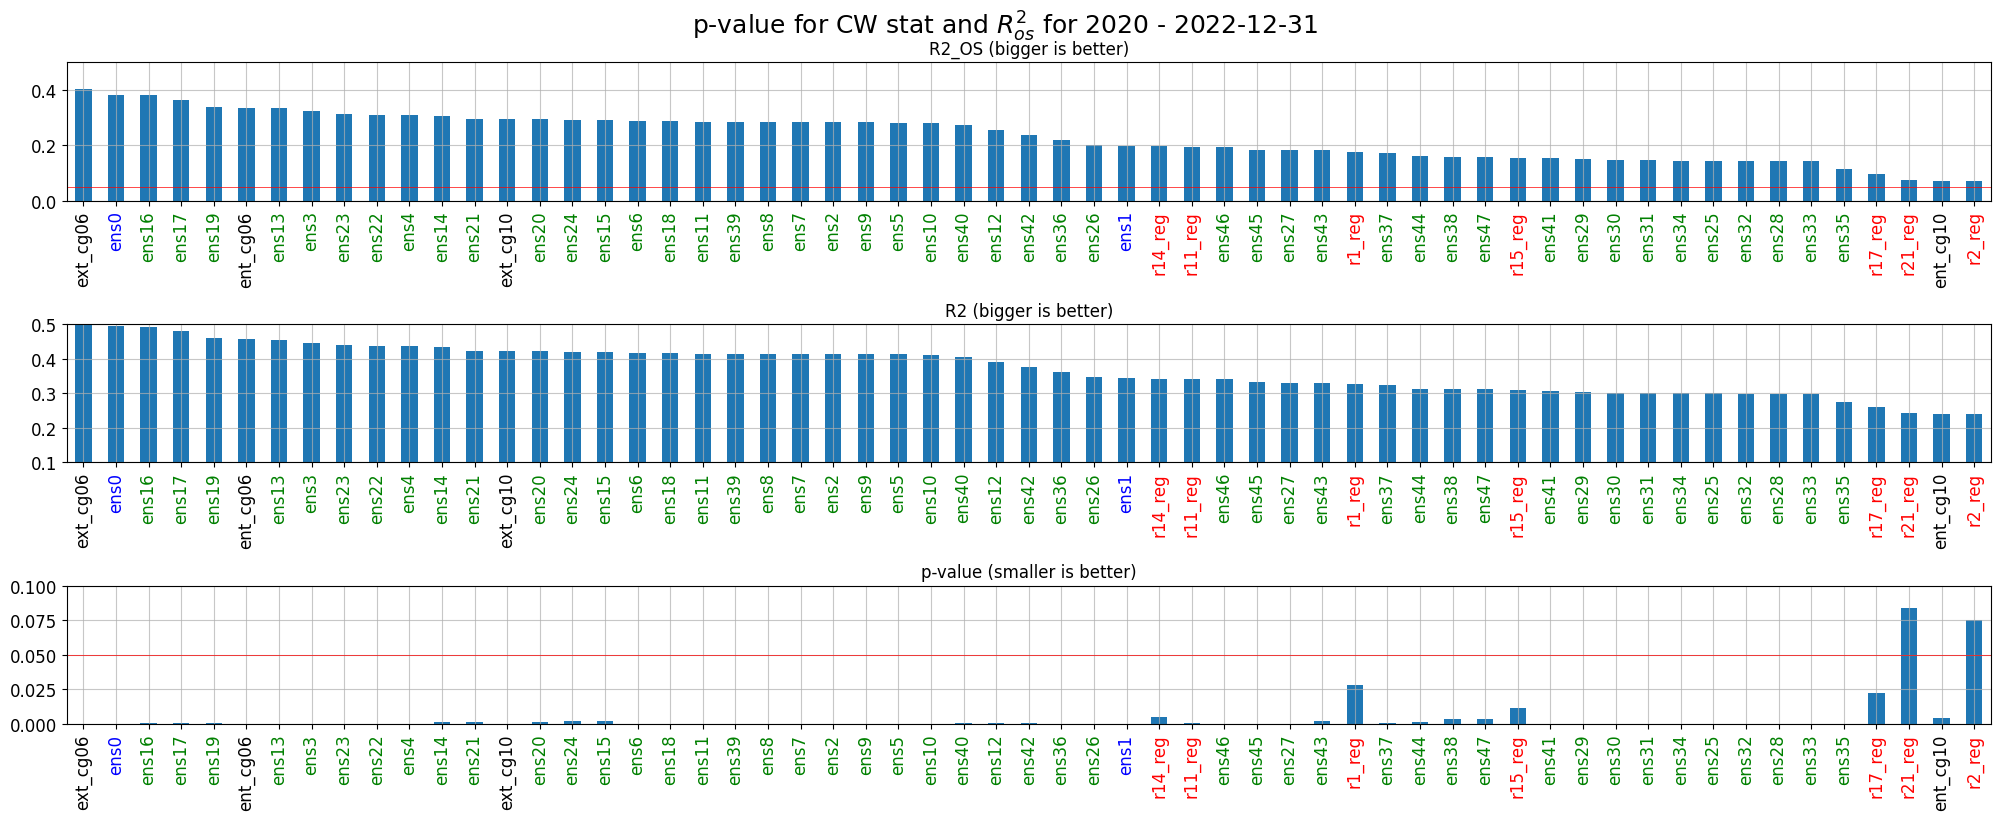

In [ ]:
p0 = '2020'
p1 = '2022-12-31'

r2, r2_os, cw = evaluation.r2_cw(pred, 'r0_reg', p0, p1, 12)
best_models = [m for m in r2_os[r2_os > 0].T.dropna().index if m in cw[cw < 0.1].T.dropna().index]
sel_index = r2_os[best_models].sort_values(ascending=False).index

fig, axs = plt.subplots(3, 1, figsize=(20, 8))
r2_os[sel_index].plot.bar(ax=axs[0], ylim=(0, 0.5), fontsize=12, title='R2_OS (bigger is better)', rot=90)
r2[sel_index].plot.bar(ax=axs[1], ylim=(0.1, 0.5), fontsize=12, title='R2 (bigger is better)', rot=90)
cw[sel_index].plot.bar(ax=axs[2], ylim=(0, 0.1), fontsize=12, title='p-value (smaller is better)', rot=90)

for ax in axs:
    for tick in ax.get_xticklabels():
        if tick.get_text() in reg_names:   tick.set_color('red')
        elif tick.get_text() in ens_ml:     tick.set_color('blue')
        elif tick.get_text() in ens_ml_reg: tick.set_color('green')
    ax.grid(alpha=0.7)
    ax.axhline(y=0.05, color='r', lw=0.5)
fig.tight_layout()
fig.suptitle(f'p-value for CW stat and $R^2_{{os}}$ for {p0} - {p1}', y=1.02, fontsize=18);

## 3-3. autocorrelation of predicted values

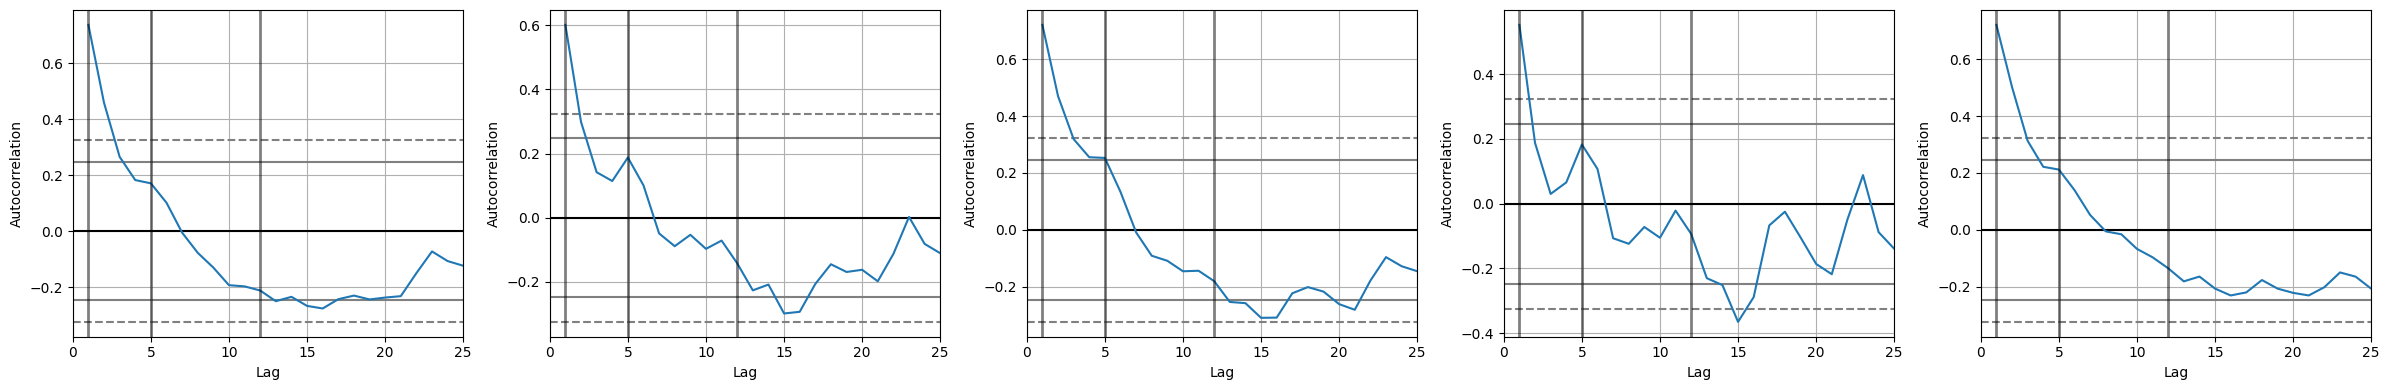

In [ ]:
ac_models = ['ens19', 'ens26', 'ens17', 'ext_cg06', 'r11_reg']

fig, axs = plt.subplots(1, 5, figsize=(24, 4))
for ax, mo in zip(axs, ac_models):
    pd.plotting.autocorrelation_plot(pred[mo], ax=ax).set_xlim([0, 25])
    ax.axvline(x=1, alpha=0.5, lw=2, color='k')
    ax.axvline(x=5, alpha=0.5, lw=2, color='k')
    ax.axvline(x=12, alpha=0.5, lw=2, color='k')
fig.tight_layout()

## 3-4. $R^2_{os}$ with various lags

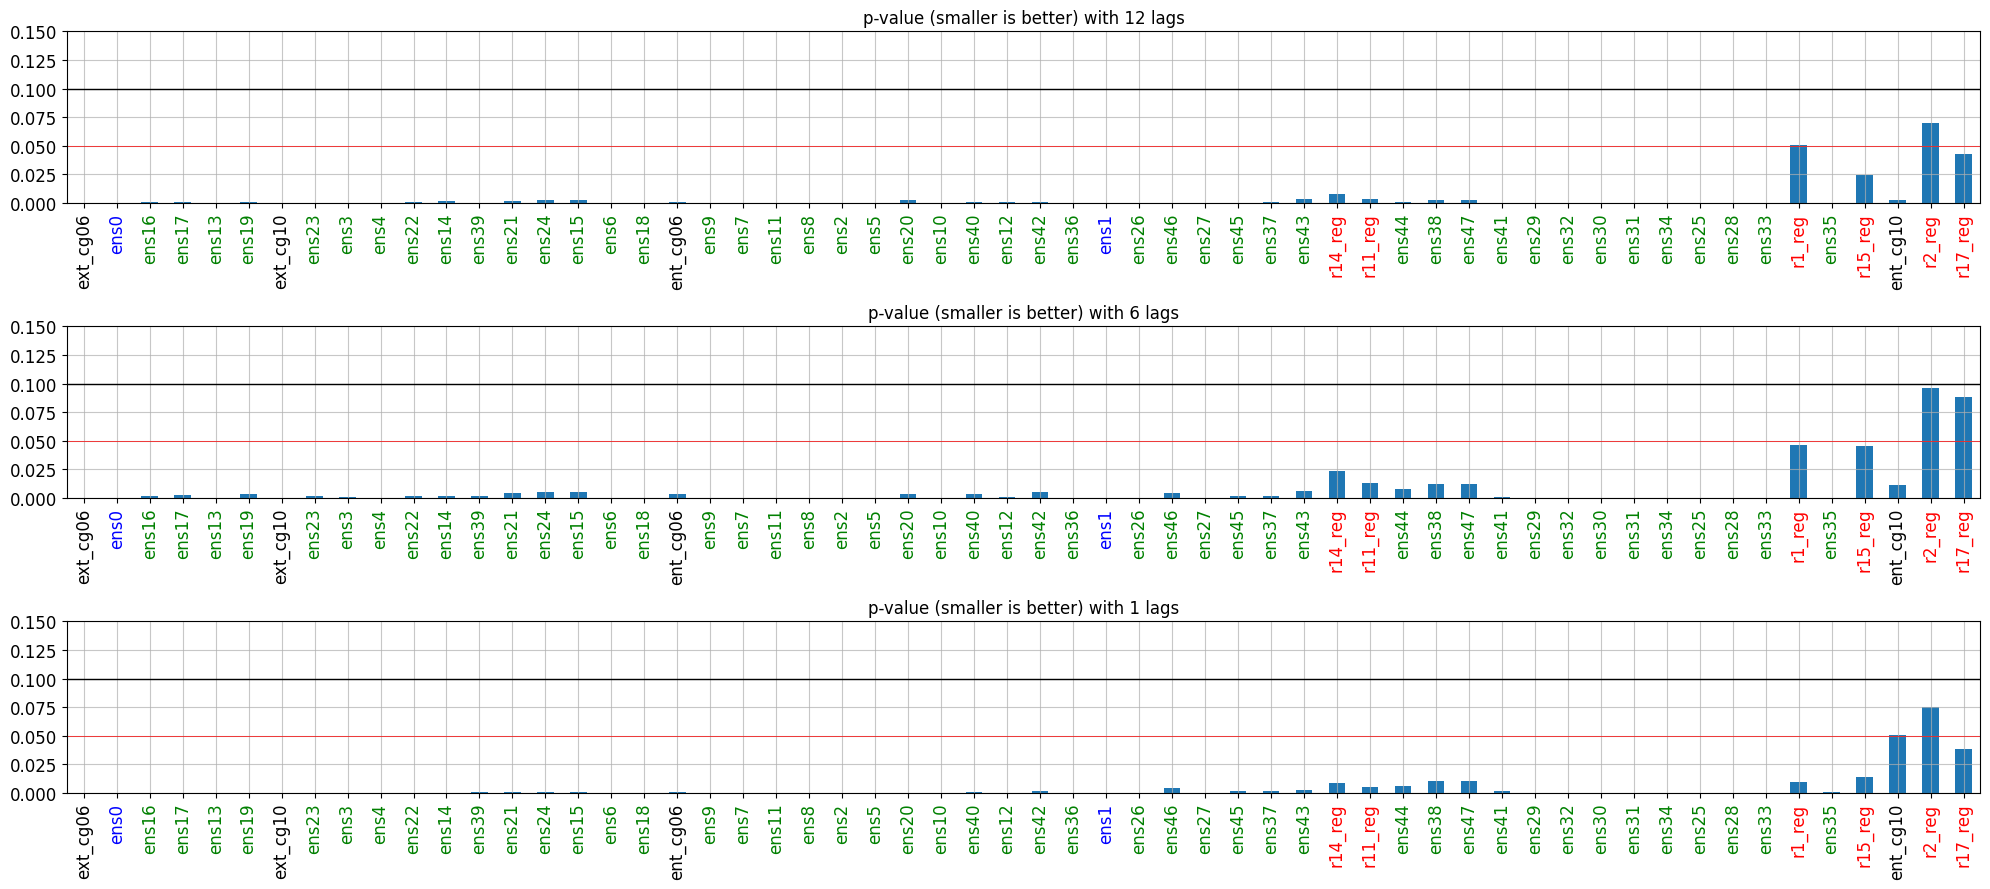

In [ ]:
p0 = '2020-1'
lags = [12, 6, 1]

fig, axs = plt.subplots(len(lags), 1, figsize=(20, 3*len(lags)))

r2, r2_os, cw = evaluation.r2_cw(pred, 'r0_reg', p0, '2023-2', 12)

best_models = [m for m in r2_os[r2_os > 0].T.dropna().index if m in cw[cw < 0.1].T.dropna().index]
r2_os_sorted = r2_os[best_models].sort_values(ascending=False)
for ax, lag in zip(axs, lags):
    r2, r2_os, cw = evaluation.r2_cw(pred, 'r0_reg', p0, '2023-2', lag)
    cw[r2_os_sorted.index].plot.bar(ax=ax, ylim=(0, 0.15), fontsize=12, title=f'p-value (smaller is better) with {lag} lags', rot=90)
    [tick.set_color('red') for tick in ax.get_xticklabels() if tick.get_text() in reg_names]
    [tick.set_color('blue') for tick in ax.get_xticklabels() if tick.get_text() in ens_ml]
    [tick.set_color('green') for tick in ax.get_xticklabels() if tick.get_text() in ens_ml_reg]
    ax.grid(alpha=0.7), ax.axhline(y=0.05, color='r', lw=0.5), ax.axhline(y=0.1, color='k', lw=1)
fig.tight_layout()

## 3-5. best model(ens17)

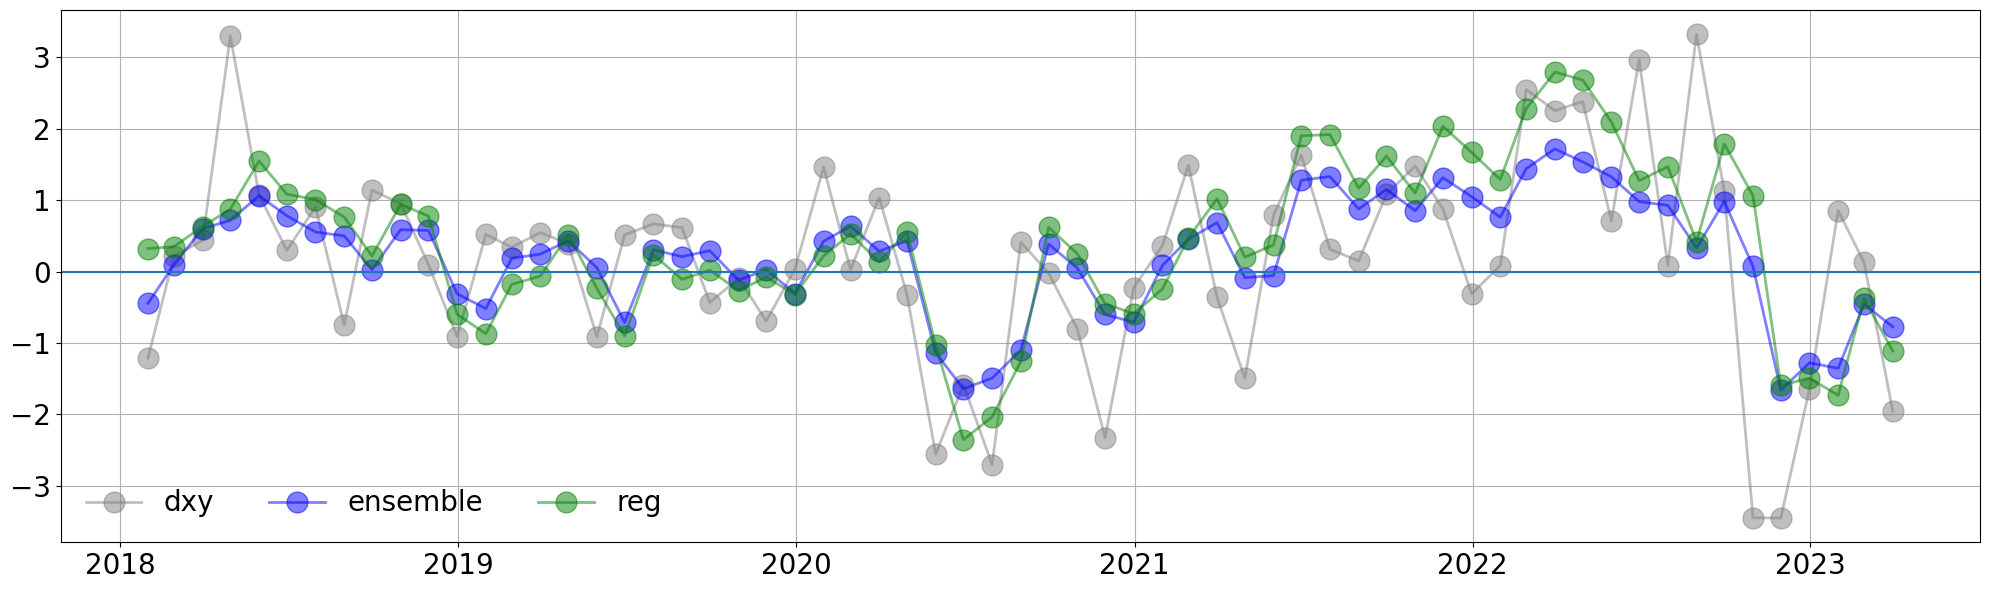

In [ ]:
sel_var = ['y', 'ens17', 'r15_reg']
df1 = pred.loc['2018':'2023', sel_var].rename(columns={'y':'dxy', 'ens17':'ensemble', 'r15_reg':'reg'}) * 100

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
for v, color in zip(df1.columns, ['gray', 'b', 'green']):
    axs.plot(df1.index, df1[v], marker='o', markersize=15, lw=2, alpha=0.5, label=v, color=color)
for ax in [axs]: 
    ax.axhline(y=0); ax.grid(); ax.legend(ncol=4, frameon=False, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

# 4. Analyze Variables

In [ ]:
suffix = 'ens17'
model_names = ens_dict[suffix]

In [ ]:
ice_dates = pd.date_range('2015', '2023', freq='AS') + MonthEnd()

In [ ]:
vr = pd.DataFrame(index=cv+gv, columns=['min', 'max'])

for v in cv + gv:
    vr.loc[v] = round(X_cg10[v].min().min(), 1), round(X_cg10[v].max().max(), 1)

## 4-1. One-way

#### calculation

In [ ]:
# ## 30분 이상 소요 ###
# processes = [Process(target=xai.one_way, args=(fm, model_names, X_dict, results_dir, models_dir, suffix, cv, gv, vr, 0.1)) for fm in ice_dates]

# for process in processes:
#     process.start()
    
# for process in processes:
#     process.join()
    
# print('Done', flush=True)

### Variable Importance

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


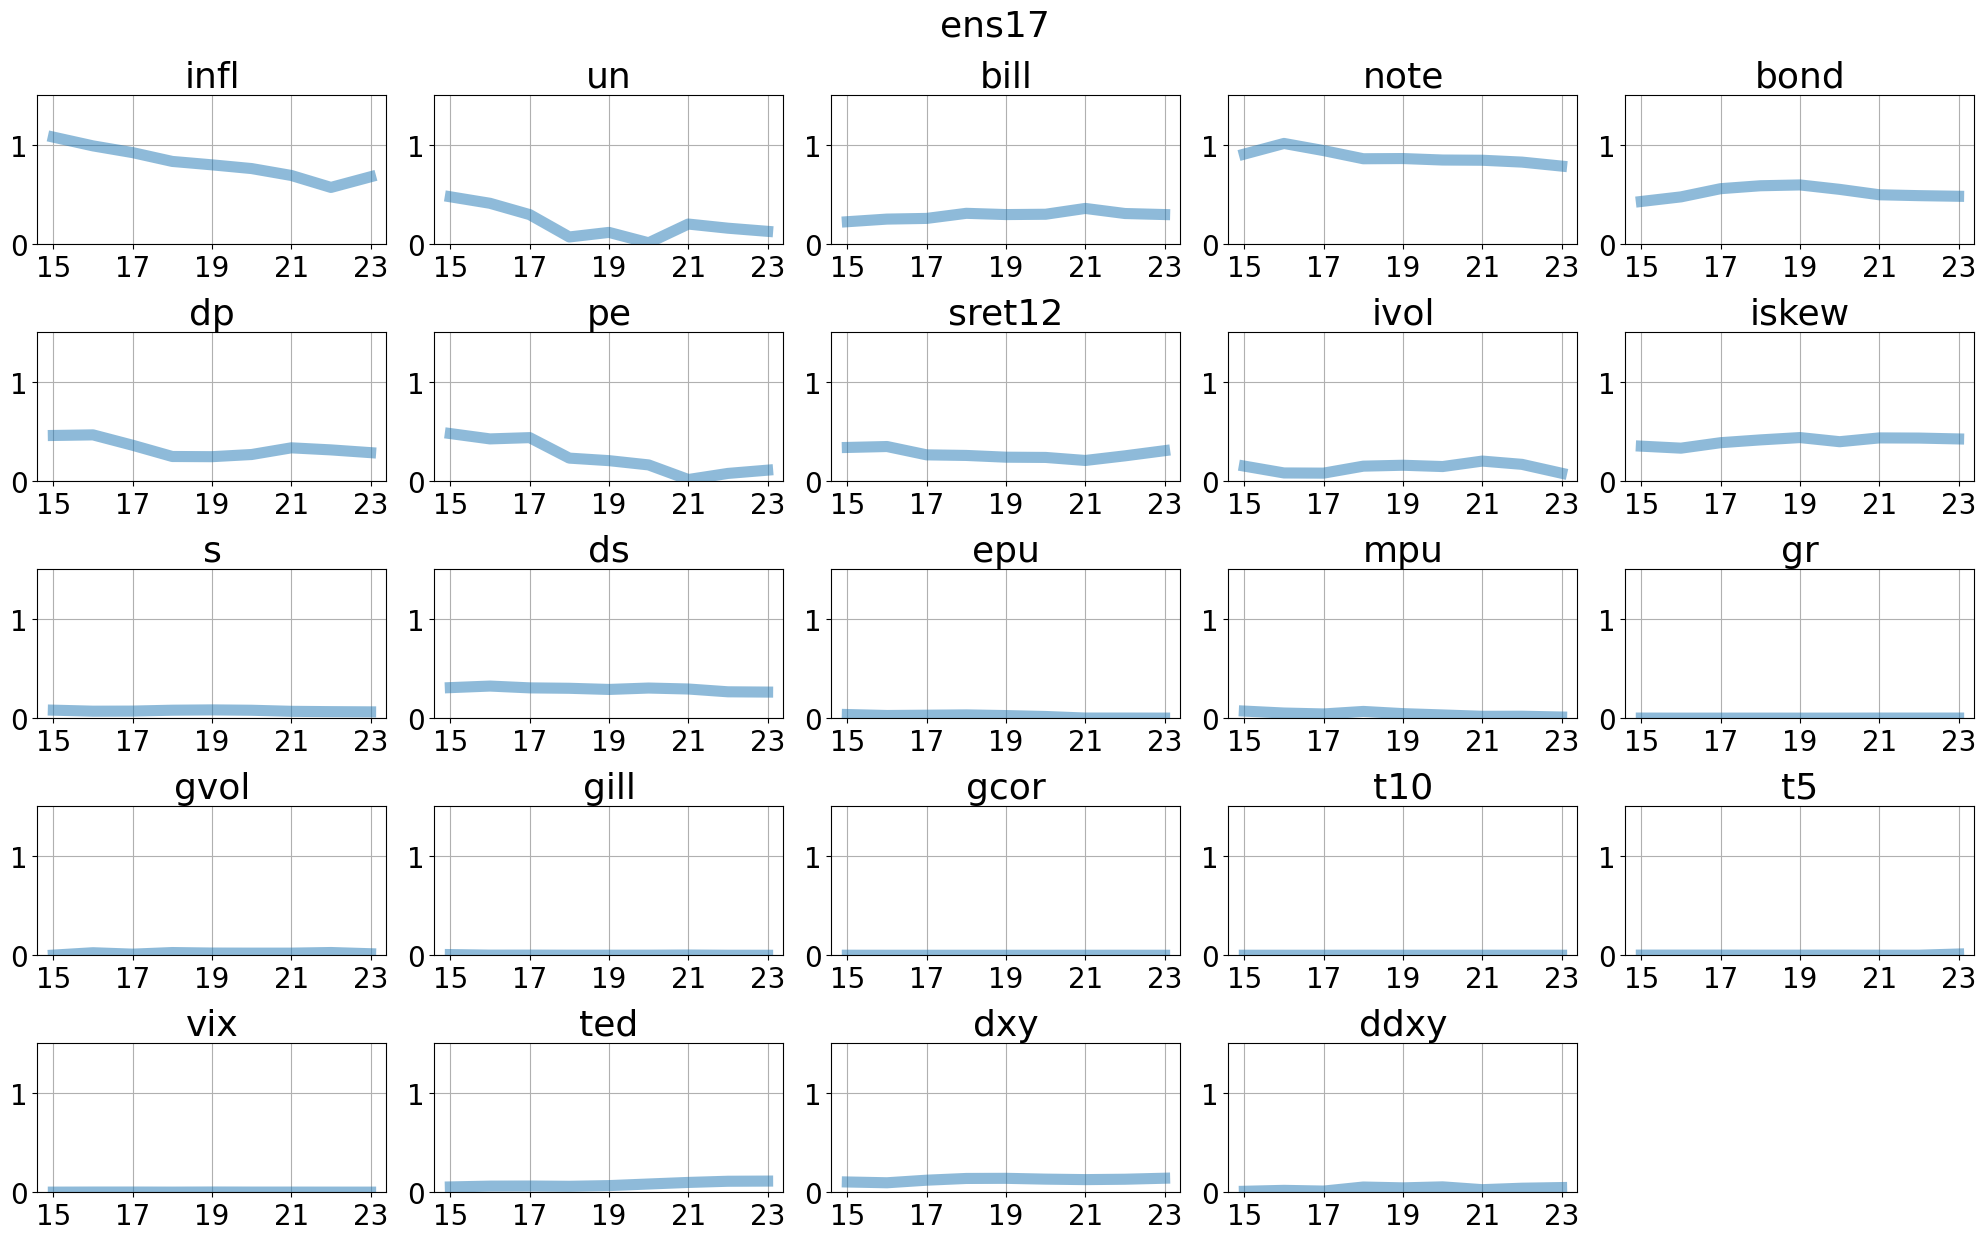

In [ ]:
pi_val = pd.DataFrame(index=ice_dates, columns = cv + gv)

for fm in tqdm(pi_val.index):       
    ICE = pd.read_pickle(f'{results_dir}/ICE_NA_{suffix}_{fm:%Y-%m}.pkl')
    pi_val.loc[fm] = xai.ice_to_vi(ICE)
    
pi_val.index = [yr[2:4] for yr in pi_val.index.astype(str)]

fig, axs = plt.subplots(5, 5, figsize=(20, 12))
for i, v in enumerate(cv + gv):
    pi_val[v].plot(ax=axs.ravel()[i], lw=8, ylim=(0, 1.5), alpha=0.5)
    axs.ravel()[i].set_title(v, fontsize=26)
    axs.ravel()[i].tick_params(axis='both', which='major', labelsize=20)
    axs.ravel()[i].grid()
axs.ravel()[-1].set_visible(False)
fig.tight_layout()
fig.suptitle(f"{suffix}", fontsize=26, y=1.03);

### PDP Plot

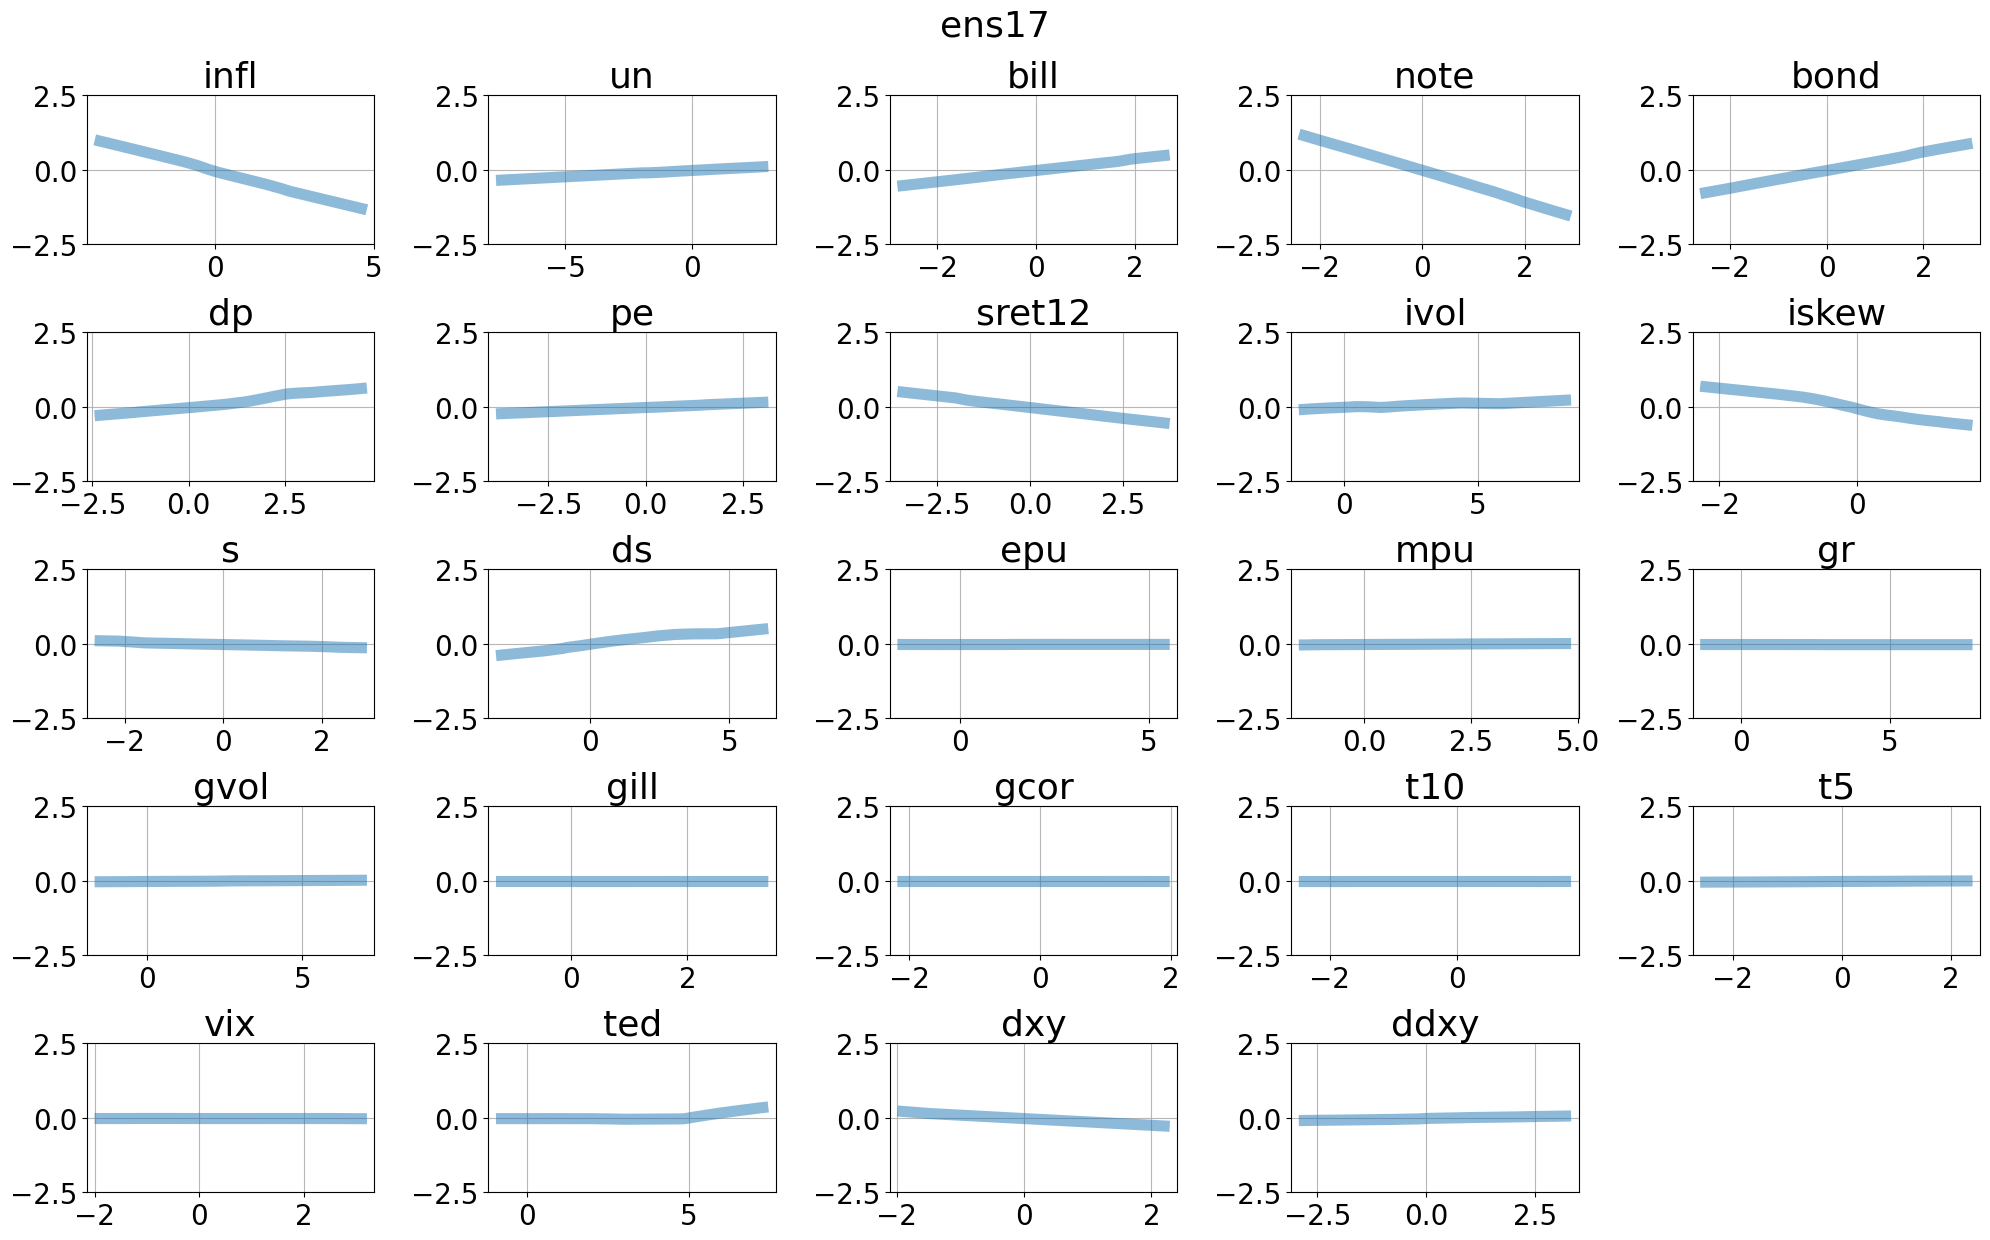

In [ ]:
ICE = pd.read_pickle(f'{results_dir}/ICE_NA_{suffix}_{fm:%Y-%m}.pkl')
pdp = xai.ice_to_pdp(ICE)

fig, axs = plt.subplots(5, 5, figsize=(20, 12))
for i, v in enumerate(cv + gv):
    pdp[v].dropna().plot(ax=axs.ravel()[i], lw=8, ylim=(-2.5, 2.5), alpha=0.5)
    axs.ravel()[i].set_title(v, fontsize=26)
    axs.ravel()[i].tick_params(axis='both', which='major', labelsize=20)
    axs.ravel()[i].grid(alpha=0.9)
axs.ravel()[-1].set_visible(False)
fig.tight_layout()
fig.suptitle(f"{suffix}", fontsize=26, y=1.03);

### ICE Plot

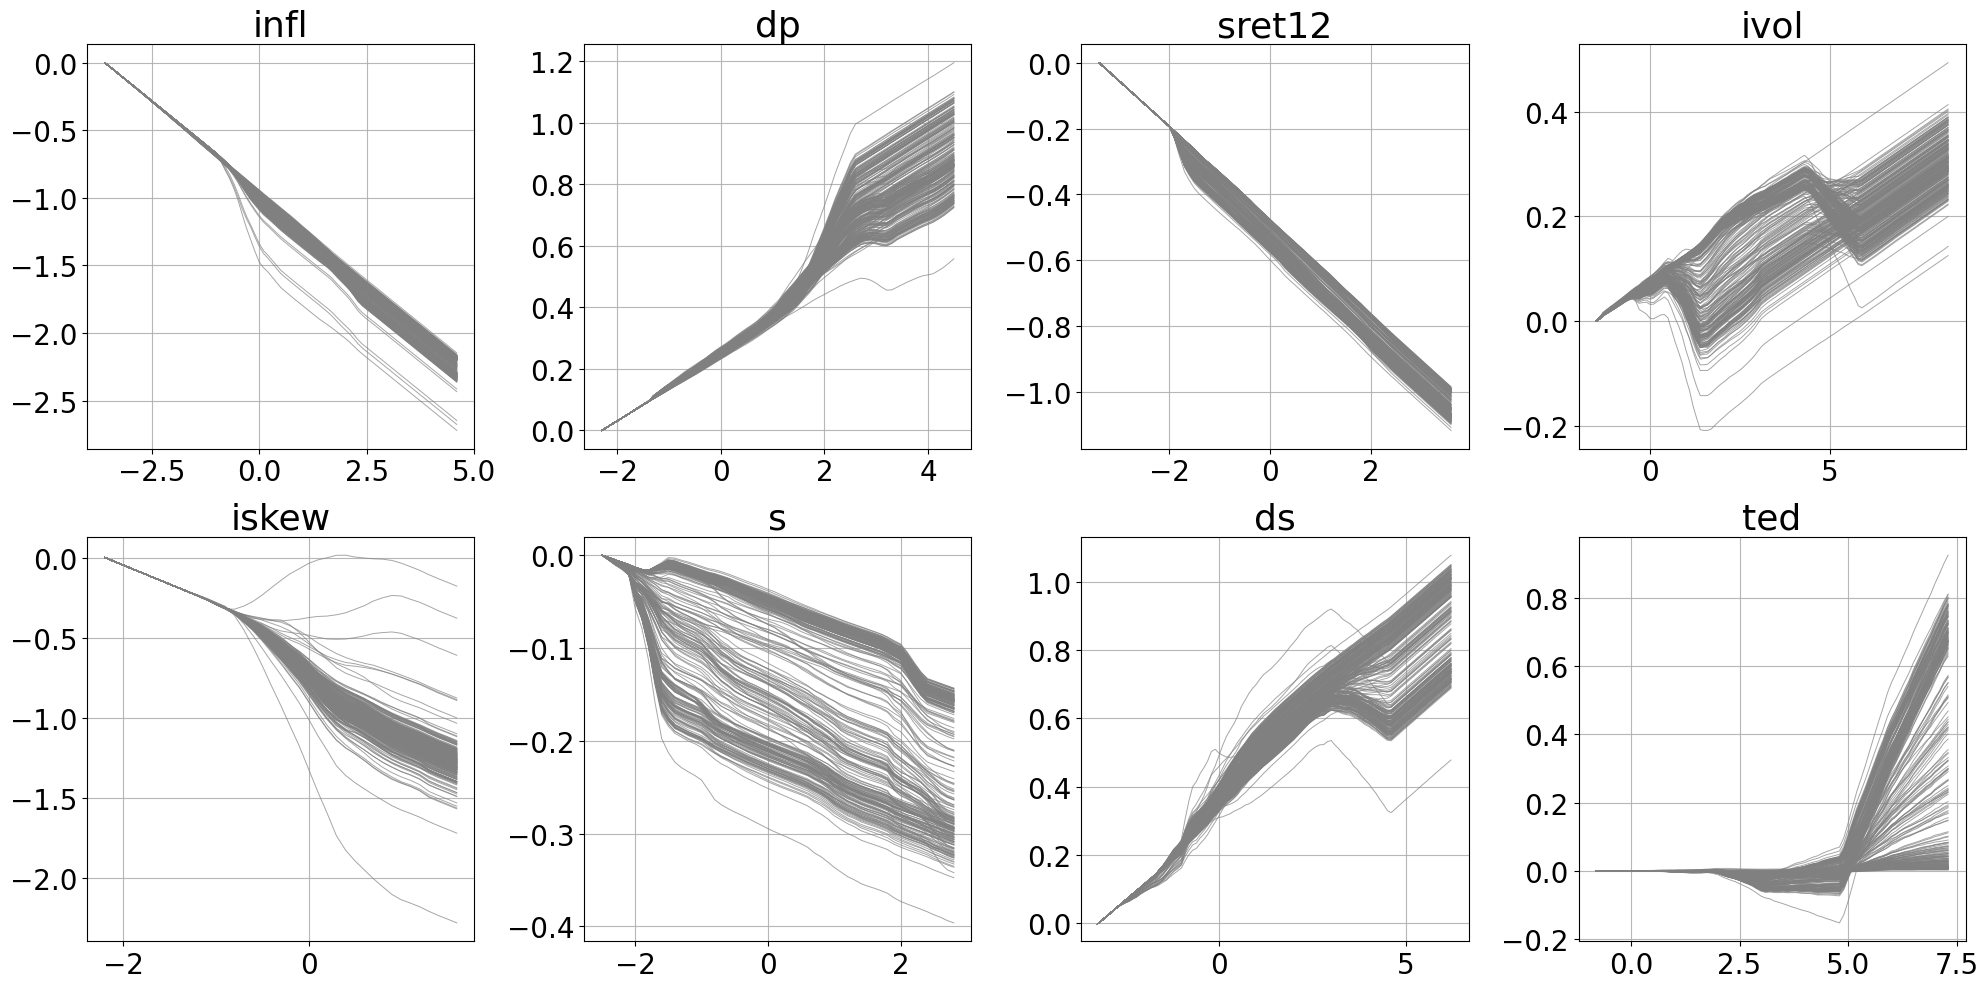

In [ ]:
ice = pd.read_pickle(f'{results_dir}/ICE_NA_{suffix}_2023-01.pkl') * 100
ice = ice.groupby(level=[1, 2], axis=1).mean()
ice_varlist = ['infl', 'dp', 'sret12', 'ivol', 'iskew', 's', 'ds', 'ted']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, v in enumerate(ice_varlist):
    df = ice[v].T
    df = (df - df.iloc[0])
    df.plot(ax=axs.ravel()[i], legend=None, color='gray', alpha=0.7, lw=0.7)
    axs.ravel()[i].set_title(v, fontsize=26)
    axs.ravel()[i].tick_params(axis='both', which='major', labelsize=20)
    axs.ravel()[i].grid(alpha=0.9)
fig.tight_layout()

## 4-2. Two-way

In [ ]:
two_var_list = [list(two_var) for two_var in itertools.combinations(['note', 'bond', 'infl', 'un', 'dp'], 2)]

### calculation

In [ ]:
#### 160분 정도 소요 #### 
# processes = [Process(target=xai.two_way, args=(pd.to_datetime('2023-01-31'), two_var, model_names, X_dict, results_dir, models_dir, suffix, cv, gv, vr, 0.1)) 
#              for two_var in two_var_list]

# for process in processes:
#     process.start()
    
# for process in processes:
#     process.join()
    
# print('Done', flush=True)

### PDP Plot

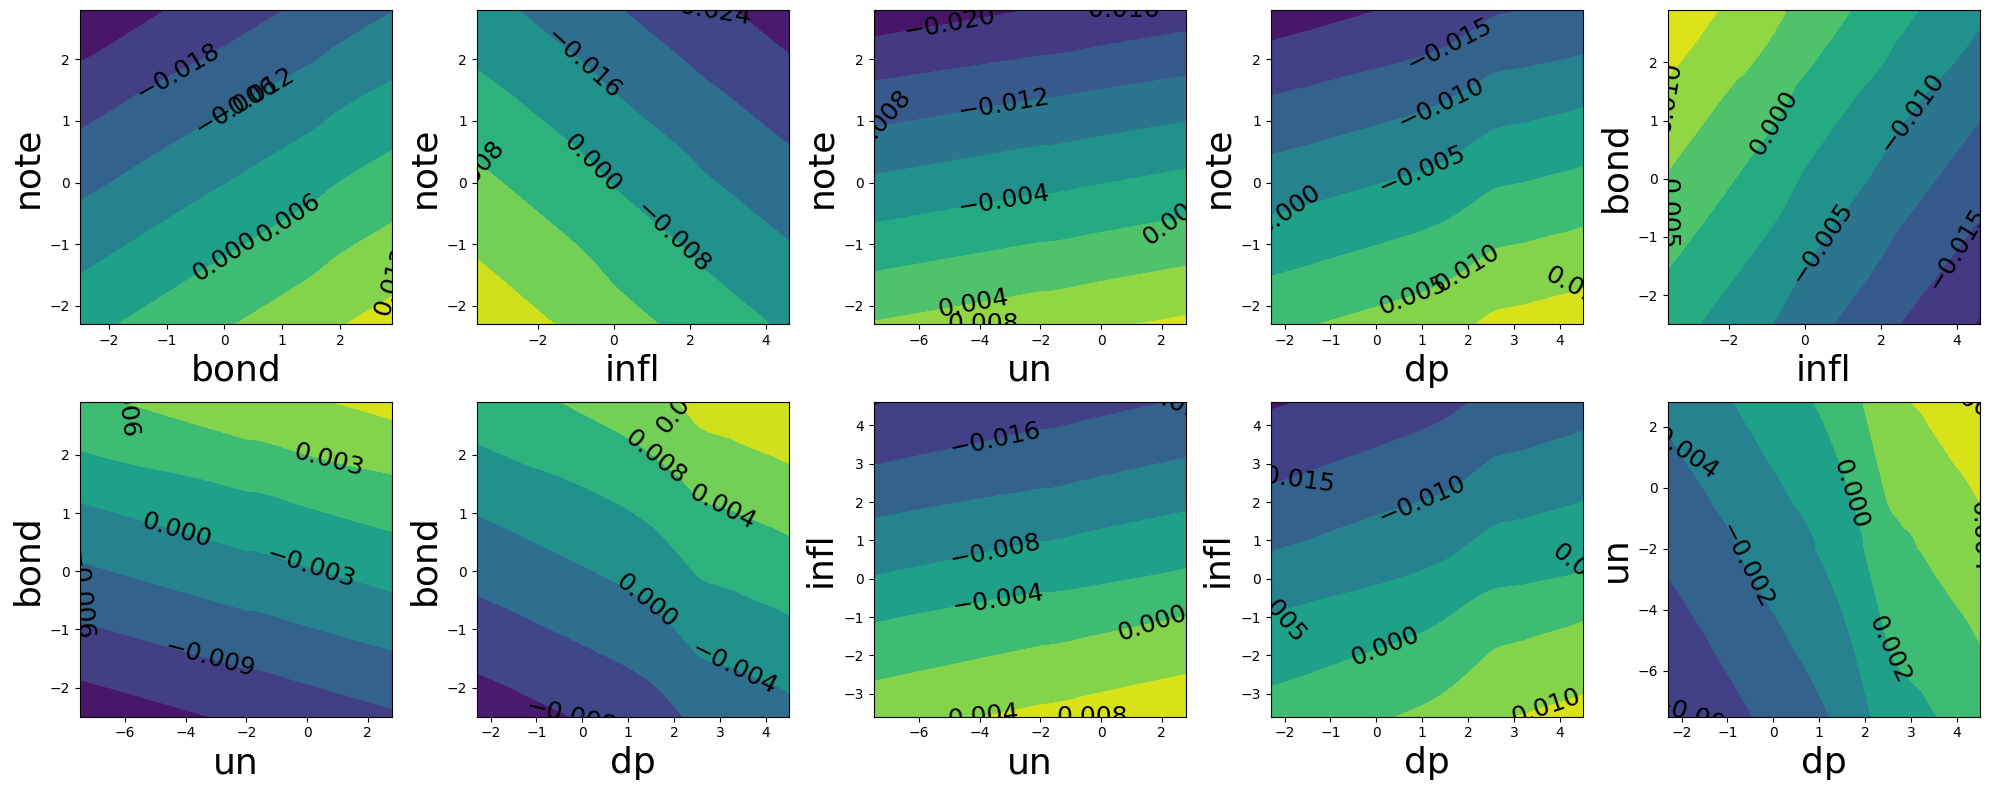

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for ax, two_var in zip(axs.ravel(), two_var_list):
    pdp = pd.read_pickle(f'{results_dir}/2way_pdp_NA_{two_var[0]}_{two_var[1]}_2023-01_{suffix}.pkl')
    pdp = pdp.groupby(level=[1], axis=1).mean()
    h = ax.contourf(pdp.columns, pdp.index, pdp)
    ax.clabel(h, inline=False, fontsize=18, colors='k')
    ax.set_xlabel(two_var[1], fontsize=26)
    ax.set_ylabel(two_var[0], fontsize=26)
fig.tight_layout()

# Forecast

In [ ]:
def ensemble_predict(model_names, X_dict, results_dir, h=1, fm=pd.to_datetime('2023-01-31')):
    
    df = []
    for name in model_names:
        data_key = name.split('_')[1]         # 'cg06', 'cg10', 'reg'
        model = joblib.load(f'{results_dir}/{name}_{fm:%Y-%m}')
        data = X_dict[data_key]
        df.append(model.predict(data))        

    pred = pd.DataFrame(np.mean(df, axis=0), index=data.index, columns=['pred']) * 100
    pred.index += MonthEnd(h)
    print(f"{h} month-ahead forecast (percent change (log diff.) from {data.index[-1]:%Y-%m} to {pred.index[-1]:%Y-%m}) is {pred['pred'].iloc[-1]:.2f}%.")
    
    return pred

In [ ]:
suffix = 'ens17'
model_names = ens_dict[suffix]

In [ ]:
pred = ensemble_predict(model_names, X_dict, models_dir, h=1)

1 month-ahead forecast (percent change (log diff.) from 2023-03 to 2023-04) is -0.85%.


In [ ]:
pred['actual'] = Xm.loc[:, idx['ddxy', 'EU']] * 100
pred_1m = pred.loc['2022-6':]

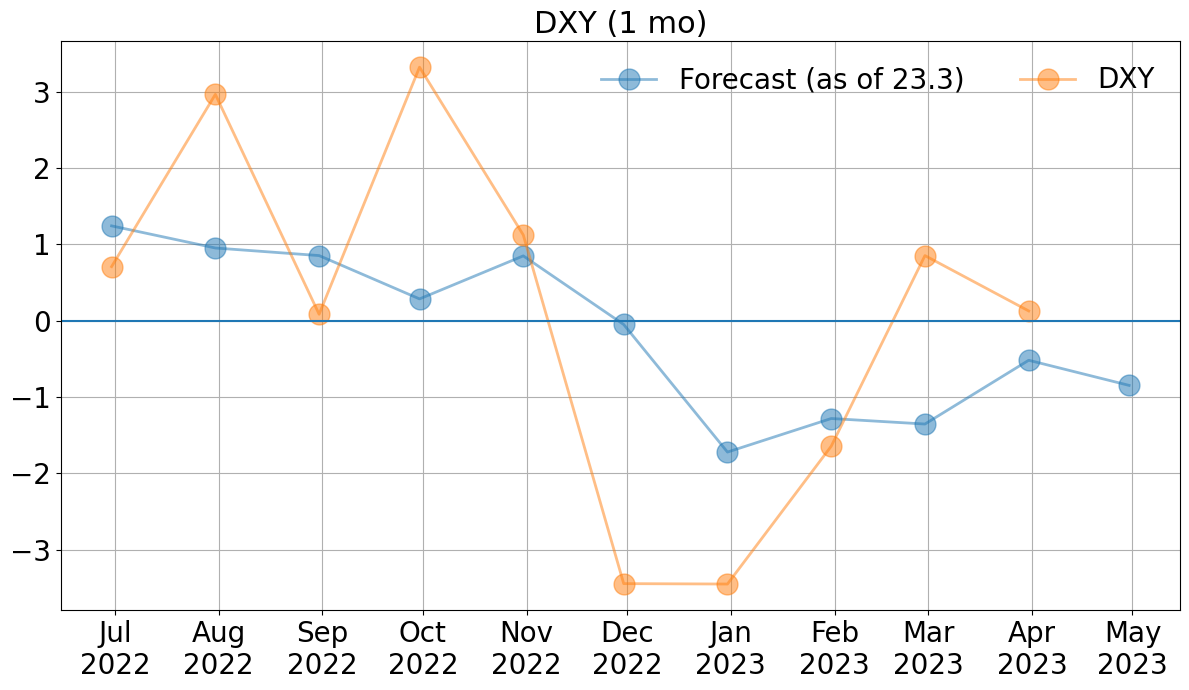

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))

axs.plot(pred_1m.index, pred_1m['pred'], label='Forecast (as of 23.3)', marker='o', markersize=15, lw=2, alpha=0.5)
axs.plot(pred_1m.index, pred_1m['actual'], label='DXY', marker='o', markersize=15, lw=2, alpha=0.5)
axs.set_title('DXY (1 mo)', fontsize=22)

for ax in [axs]: 
    ax.axhline(y=0)
    ax.grid()
    ax.legend(ncol=4, frameon=False, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
fig.tight_layout()